## 讀書會第三次大綱
1. 介紹使用到的套件
2. 將資料進行前處理
3. lexicon-based 的主題模型
4. LDA 主題模型
5. 視覺化主題模型
6. GuidedLDA
7. 主題模型的應用

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Social_Media_Analysis/HW3')

Mounted at /content/drive


## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [3]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.6 MB/s eta 0:00:00


In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. 資料前處理

In [6]:
data = pd.read_csv("raw_data/living_world_entertainment_20240401to30_ebc.csv")  # 匯資料
print(data.shape)
data.head(3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5452, 7)


,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,娛樂,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,EBC
1,2,結婚28年！余皓然突爆「前陣子離婚」 無奈真相曝光｜東森新聞,https://news.ebc.net.tw/news/article/407782,2024-03-01 11:14:00,娛樂,男星王中平與余皓然結婚28年，一家四口相當幸福，可以說是演藝圈的模範夫妻，沒想到余皓然近期卻...,EBC
2,3,勝過Sandy！吳宗憲「最美三女兒」高顏值曝光｜東森新聞,https://news.ebc.net.tw/news/article/407801,2024-03-01 12:33:00,娛樂,綜藝天王吳宗憲有3女1子，其中大女兒Sandy（吳姍儒）和小兒子鹿希派（吳睿軒）為大眾所熟識...,EBC


In [7]:
# 移除網址格式
# 只留下中文字
data["artContent"] = data["artContent"].str.replace("(http|https)://.*", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("(http|https)://.*", "", regex=True)
data["artContent"] = data["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data['content'] = data['artContent']


data = data.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
data.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate
0,啦啦隊女孩外表看起來光鮮亮麗其實生活壓力非常大尤其剛出道的啦啦隊上場次數不多薪水並不高東森新...,https://news.ebc.net.tw/news/article/407763,娛樂,2024-03-01 07:00:00
1,男星王中平與余皓然結婚年一家四口相當幸福可以說是演藝圈的模範夫妻沒想到余皓然近期卻自曝兩人離...,https://news.ebc.net.tw/news/article/407782,娛樂,2024-03-01 11:14:00
2,綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿軒為大眾所熟識而憲哥曾公開稱讚小女兒吳...,https://news.ebc.net.tw/news/article/407801,娛樂,2024-03-01 12:33:00


In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.extend(["關注","台中市","帶領","東縣","確保","地區"])

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

data["words"] = data["content"].apply(getToken)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/HW3/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/HW3/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ue0031ce2155a9ef6090ec1cd6878d3e5.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.ue0031ce2155a9ef6090ec1cd6878d3e5.cache
Loading model cost 6.085 seconds.
DEBUG:jieba:Loading model cost 6.085 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,啦啦隊女孩外表看起來光鮮亮麗其實生活壓力非常大尤其剛出道的啦啦隊上場次數不多薪水並不高東森新...,https://news.ebc.net.tw/news/article/407763,娛樂,2024-03-01 07:00:00,"[啦啦隊, 女孩, 外表, 光鮮亮麗, 生活, 壓力, 尤其, 剛出道, 啦啦隊, 上場, ..."
1,男星王中平與余皓然結婚年一家四口相當幸福可以說是演藝圈的模範夫妻沒想到余皓然近期卻自曝兩人離...,https://news.ebc.net.tw/news/article/407782,娛樂,2024-03-01 11:14:00,"[男星, 王中平, 皓然, 結婚, 一家, 四口, 相當, 幸福, 演藝圈, 模範, 夫妻,..."
2,綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿軒為大眾所熟識而憲哥曾公開稱讚小女兒吳...,https://news.ebc.net.tw/news/article/407801,娛樂,2024-03-01 12:33:00,"[綜藝, 天王, 吳宗憲, 女子, 女兒, 吳姍儒, 小兒子, 鹿希派, 吳睿軒, 大眾, ..."
3,女星歐若拉去年與交往個月的男友閃婚原以為對方是真命天子沒想到事後發現前夫外遇吸毒而歐若拉竟然...,https://news.ebc.net.tw/news/article/407880,娛樂,2024-03-01 19:22:00,"[女星, 歐若拉, 去年, 交往, 男友, 閃婚, 原以, 對方, 真命天子, 沒想到, 事..."
4,台灣正妹網紅胎尼以大尺度風格在網上擁有不小的人氣在社群舊名上有超過萬追隨者平時就在自己拍攝大...,https://news.ebc.net.tw/news/article/407909,娛樂,2024-03-01 22:11:00,"[台灣, 正妹, 網紅, 胎尼以, 尺度, 風格, 網上, 擁有, 不小, 人氣, 社群, ..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [9]:
data['artCatagory'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['娛樂', '生活', '國際'], dtype=object)

In [10]:
## 定義主題
living_cnt = data.loc[data['artCatagory'] == '生活',:]['words'].explode().value_counts().head(100)
pprint("\", \"".join(living_cnt.index))

('地震", "表示", "民眾", "發生", "網友", "已經", "台灣", "影響", "花蓮", "現在", "目前", "媽祖", "真的", '
 '"業者", "發現", "時間", "問題", "出現", "一起", "比較", "指出", "覺得", "公司", "希望", "天氣", '
 '"看到", "持續", "氣象", "許多", "有人", "大樓", "使用", "強震", "今日", "工作", "進行", "造成", '
 '"人員", "一名", "今天", "短暫", "現場", "正在", "規模", "日本", "知道", "鋒面", "活動", "無法", '
 '"認為", "應該", "今年", "局部", "直接", "機會", "相當", "北部", "台北", "店家", "提醒", "山區", '
 '"衛生局", "提供", "各地", "相關", "安全", "地方", "狀況", "找尋", "需要", "部分", "以上", "注意", '
 '"之後", "一些", "冠軍", "老闆", "朋友", "搜救", "發文", "最後", "樂團", "懸賞", "透過", "特別", '
 '"生活", "萬哈林", "聽團", "消費者", "超過", "陣雨", "附近", "導致", "對此", "嚴重", "餘震", "容易", '
 '"小時", "萬元", "未來')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
entertainment_cnt = data.loc[data['artCatagory'] == '娛樂',:]['words'].explode().value_counts().head(100)
pprint("\", \"".join(entertainment_cnt.index))

('表示", "黃子佼", "網友", "粉絲", "台灣", "真的", "一起", "影片", "藝人", "現在", "已經", "節目", '
 '"兩人", "知道", "汪小菲", "透露", "發文", "希望", "許多", "覺得", "看到", "對此", "當時", "對方", '
 '"公司", "發現", "認為", "報導", "樂團", "直播", "去年", "相當", "正在", "今日", "一直", "回應", '
 '"未成年", "日本", "曝光", "工作", "分享", "離婚", "朋友", "留言", "最後", "照片", "媽媽", "聽團", '
 '"沒想到", "時間", "冠軍", "事情", "拍攝", "演藝圈", "近日", "消息", "公開", "事件", "臉書", "道歉", '
 '"之後", "結婚", "懸賞", "找尋", "網紅", "萬哈林", "社群", "過去", "爆料", "生活", "發生", "紛紛", '
 '"台北", "日前", "宣布", "指出", "目前", "這次", "韓國", "今天", "媒體", "女兒", "透過", "律師", '
 '"週刊", "成為", "統神", "引起", "突然", "現場", "問題", "感到", "外界", "提到", "活動", "女星", '
 '"演員", "無法", "應該", "強調')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
global_cnt = data.loc[data['artCatagory'] == '國際',:]['words'].explode().value_counts().head(100)
pprint("\", \"".join(global_cnt.index))

('美國", "表示", "中國", "發生", "報導", "日本", "台灣", "已經", "大陸", "民眾", "一名", "發現", "目前", '
 '"當地", "警方", "進行", "指出", "男子", "出現", "事件", "總統", "以色列", "公司", "時間", "造成", '
 '"網友", "伊朗", "國家", "攻擊", "女子", "認為", "工作", "調查", "台幣", "看到", "當時", "全球", '
 '"影片", "導致", "現場", "媒體", "現在", "俄羅斯", "這是", "問題", "拜登", "安全", "記者", "有人", '
 '"死亡", "總理", "一起", "正在", "影響", "許多", "今年", "包括", "今天", "超過", "地震", "遭到", '
 '"經濟", "希望", "這起", "宣布", "成為", "傳出", "政府", "飛彈", "透過", "最後", "引發", "畫面", '
 '"持續", "過去", "這次", "去年", "人員", "透露", "員工", "提供", "無法", "情況", "突然", "香港", '
 '"接受", "真的", "直接", "沒想到", "行為", "醫院", "相關", "嚴重", "川普", "相當", "當局", "使用", '
 '"受到", "原因", "烏克蘭')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
custom_topic_word = {
    "生活": [
        "地震"
        "民眾",
        "網友",
        "台灣",
        "花蓮",
        "媽祖",
        "業者"
        "公司",
        "天氣"
        "氣象",
        "大樓",
        "強震",
        "人員",
        "現場"
        "規模",
        "日本",
        "鋒面",
        "活動",
        "局部",
        "北部",
        "台北",
        "店家",
        "提醒",
        "山區",
        "衛生局",
        "安全",
        "狀況",
        "注意",
        "冠軍",
        "老闆"
        "搜救",
        "發文",
        "樂團",
        "懸賞",
        "萬哈林",
        "聽團",
        "消費者",
        "陣雨",
        "餘震",
    ],
    "娛樂": [
        "黃子佼",
        "網友",
        "粉絲",
        "台灣",
        "影片",
        "藝人",
        "節目",
        "汪小菲",
        "發文",
        "樂團",
        "直播",
        "回應",
        "未成年",
        "日本",
        "曝光",
        "分享",
        "離婚",
        "留言",
        "照片",
        "聽團",
        "冠軍",
        "拍攝",
        "演藝圈",
        "公開",
        "臉書",
        "道歉",
        "懸賞",
        "結婚",
        "網紅",
        "萬哈林",
        "社群",
        "爆料",
        "台北",
        "韓國",
        "媒體",
        "律師",
        "週刊",
        "統神",
        "外界",
        "活動",
        "女星",
        "演員",
        "演唱會",
    ],
    "國際": [
        "美國",
        "中國"
        "報導",
        "日本",
        "台灣",
        "大陸",
        "警方",
        "總統",
        "以色列",
        "伊朗",
        "國家",
        "攻擊",
        "女子",
        "台幣",
        "全球",
        "影片",
        "現場",
        "俄羅斯",
        "拜登",
        "安全",
        "記者",
        "總理",
        "死亡",
        "地震",
        "經濟",
        "政府",
        "飛彈",
        "引發",
        "香港",
        "醫院",
        "川普",
        "當局",
    ],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
vocabularies

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['中國報導', '人員', '以色列', '伊朗', '俄羅斯', '全球', '公開', '冠軍', '分享', '北部',
       '台北', '台幣', '台灣', '回應', '國家', '地震', '地震民眾', '外界', '大樓', '大陸',
       '天氣氣象', '女子', '女星', '媒體', '媽祖', '安全', '局部', '山區', '川普', '店家', '引發',
       '強震', '影片', '律師', '懸賞', '拍攝', '拜登', '提醒', '攻擊', '政府', '日本', '曝光',
       '未成年', '業者公司', '樂團', '死亡', '汪小菲', '注意', '活動', '消費者', '演員', '演唱會',
       '演藝圈', '照片', '爆料', '狀況', '現場', '現場規模', '留言', '當局', '發文', '直播',
       '社群', '節目', '粉絲', '結婚', '統神', '經濟', '網友', '網紅', '總理', '總統', '美國',
       '老闆搜救', '聽團', '臉書', '花蓮', '萬哈林', '藝人', '衛生局', '記者', '警方', '週刊',
       '道歉', '醫院', '鋒面', '陣雨', '離婚', '韓國', '飛彈', '餘震', '香港', '黃子佼'],
      dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [16]:
data_corpus = data['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
data_matrix = vectorizer.fit_transform(data_corpus)

data_matrix = data_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
data_matrix.shape
# (文章數量，詞彙數)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5452, 93)

In [18]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = data_matrix[:, idx].sum(axis=1)

df_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_生活,topic_娛樂,topic_國際
0,0,3,1
1,0,15,0
2,4,9,1
3,0,10,0
4,7,18,6
...,...,...,...
5447,17,16,33
5448,1,0,4
5449,5,1,7
5450,0,1,5


In [19]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_生活,topic_娛樂,topic_國際
0,0.000000,0.750000,0.250000
1,0.000000,1.000000,0.000000
2,0.285714,0.642857,0.071429
3,0.000000,1.000000,0.000000
4,0.225806,0.580645,0.193548


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**4.1 正式處理新聞**

In [20]:
docs = data['words'].to_list()
docs[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['啦啦隊',
 '女孩',
 '外表',
 '光鮮亮麗',
 '生活',
 '壓力',
 '尤其',
 '剛出道',
 '啦啦隊',
 '上場',
 '次數',
 '薪水',
 '並不高',
 '東森',
 '新聞',
 '獨家',
 '採訪',
 '樂天',
 '女孩',
 '成員',
 '禹菡',
 '音漢',
 '在家',
 '小心',
 '扭傷',
 '腰部',
 '醫生',
 '診斷',
 '椎間盤',
 '突出',
 '球場',
 '受傷',
 '無法',
 '領職災',
 '給付',
 '球季',
 '被迫',
 '無薪',
 '生活',
 '入不敷出',
 '這是',
 '樂天',
 '女孩',
 '禹菡',
 '兩個',
 '禮拜',
 '舞台',
 '賣力',
 '勁歌熱舞',
 '模樣',
 '青春',
 '活力',
 '形象',
 '台下',
 '粉絲',
 '大飽眼福',
 '回台',
 '變成',
 '這副',
 '模樣',
 '樂天',
 '女孩',
 '禹菡',
 '好像',
 '真的',
 '會動',
 '食族',
 '減重',
 '菜單',
 '週瘦',
 '公斤',
 '快點',
 '截圖',
 '勤跑',
 '復健',
 '診所',
 '接受',
 '治療',
 '原來',
 '禹菡',
 '一時',
 '疏忽',
 '造成',
 '腰部',
 '嚴重',
 '傷勢',
 '樂天',
 '女孩',
 '禹菡',
 '彎下去',
 '抱貓',
 '膝蓋',
 '彎下去',
 '沒想到',
 '一聲',
 '電流',
 '電過',
 '半邊',
 '痛到',
 '辦法',
 '叫耶因',
 '整個',
 '癱軟',
 '地上',
 '整個',
 '扶著',
 '牆壁',
 '爬上來',
 '一直',
 '痛回',
 '家中',
 '意外',
 '扭傷',
 '腰部',
 '事後',
 '檢查',
 '醫生',
 '診斷',
 '出是',
 '椎間盤',
 '突出',
 '休息',
 '最少',
 '三個',
 '啦啦隊',
 '薪水',
 '通告',
 '藝人',
 '相同',
 '一場',
 '一場',
 '無法',
 '上台',
 '應援',
 '生計',
 '受到',
 '巨大',
 '衝擊',
 '樂天',
 '女孩',

In [21]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<17866 unique tokens: ['一下', '一場', '一時', '一直', '一聲']...>


In [22]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一下: 0
一場: 1
一時: 2
一直: 3
一聲: 4
三個: 5
三月: 6
上台: 7
上場: 8
不像: 9
事後: 10
休息: 11


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [23]:
pprint(" ".join(data['words'].iloc[600]))


('大馬 鬼才 歌手 明志 昨天 愚人節 這天 宣布 舉辦 告別式 驚動 整個 華人 娛樂圈 直到 今日 凌晨 出面 發聲 證實 這是 一場 生前 告別式 '
 '強調 開玩笑 文章 曝光 受到 粉絲 批評 揚言 退粉 明志 今天 凌晨 點多 臉書 發文 證實 這場 活動 生前 告別式 語重心長 短短的 一天 感觸 '
 '很深 看到 真正 關心 看到 許多 落井下石 覺得 幸運 是還 能夠 看到 喪禮 體驗 體驗 不到 事情 明志 解釋 背後 真正 含意 去年 整年 裡我 '
 '發生 許多 面對 來自 四面八方 壓力 身體健康 出現 警訊 出入 醫院 急診 身邊 許多 朋友 寵物 許多 名人 離開 感到 措手不及 這也 意識 '
 '生前 規劃 重要性 一首 歌曲 拍攝 計劃 要辦 一場 生前 告別式 計劃 拍成 紀錄片 目的 想要 生前 規劃 這件 分享 社會 大眾 文章 曝光 '
 '粉絲 各有不同 看法 許多 認為 玩笑 過頭 已故 香港 巨星 張國榮 舉例 香港 張國榮 先生 逝世 早已 愚人節 生死 謝謝 華人 文化 帶來 生死 '
 '教育 反思 心中 哥哥 已經 驚嚇 玩笑 認為 志在 愚人節 這天 詐死 不太 恰當 無聊 以為 出名 這套 玩太大 欣賞 創作 愚人節 愚人節 死亡 '
 '開玩笑 有點 文章 裡面 一句 道歉 擔心 尤其 海外 歌迷 事情 一點 成熟 粉絲 明志 行為 表示 支持 高興 真的 喜歡 演唱 製作 希望 看到 '
 '兄弟 好好 嚇死 明志哥 別鬧 沒事 一直 欣賞 加油 重要 沒事 沒事 好會 繼續 支持')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 第600篇文章中每個字詞出現的次數
dictionary.doc2bow(data['words'].iloc[600])[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 2),
 (3, 1),
 (25, 1),
 (37, 1),
 (48, 1),
 (63, 1),
 (91, 1),
 (94, 1),
 (98, 3),
 (123, 1)]

In [25]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
type(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [27]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：
<br>
數字越大，代表該字詞在該文章的重要性越高
<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [28]:
ldamodel.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.006*"台灣" + 0.005*"表示" + 0.004*"國家" + 0.004*"民眾" + 0.003*"美國" + 0.003*"全球" + 0.003*"指出" + 0.003*"目前" + 0.003*"今年" + 0.003*"使用"'),
 (1,
  '0.007*"日本" + 0.007*"表示" + 0.006*"地震" + 0.005*"台灣" + 0.004*"飛彈" + 0.004*"已經" + 0.004*"目前" + 0.004*"民眾" + 0.004*"發生" + 0.004*"現在"'),
 (2,
  '0.008*"網友" + 0.008*"媽祖" + 0.007*"表示" + 0.005*"真的" + 0.004*"一名" + 0.004*"孩子" + 0.003*"影片" + 0.003*"一起" + 0.003*"女兒" + 0.003*"活動"'),
 (3,
  '0.006*"菲律賓" + 0.006*"表示" + 0.006*"學生" + 0.005*"發射" + 0.004*"已經" + 0.004*"中國" + 0.004*"男友" + 0.003*"夜市" + 0.003*"台灣" + 0.003*"網友"'),
 (4,
  '0.010*"民眾" + 0.008*"發生" + 0.005*"以色列" + 0.005*"已經" + 0.005*"地震" + 0.005*"警方" + 0.005*"造成" + 0.005*"目前" + 0.005*"表示" + 0.004*"男子"'),
 (5,
  '0.011*"鋒面" + 0.010*"天氣" + 0.010*"局部" + 0.010*"氣象" + 0.009*"短暫" + 0.008*"陣雨" + 0.007*"影響" + 0.007*"山區" + 0.007*"台灣" + 0.007*"北部"'),
 (6,
  '0.006*"表示" + 0.005*"網友" + 0.005*"報導" + 0.005*"發現" + 0.004*"日本" + 0.004*"中國" + 0.004*"公司" + 0.004*"美國" + 0.004*"已經" + 0.004*"工作"'),
 (7,
  '0.016*"地震" + 0.00

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：春節旅遊
+ 主題二：中國科技產業
+ 主題三：股市新聞
+ 主題四：中國股市
+ ...
+ 主題十：中美貿易

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [29]:
ldamodel.get_document_topics(corpus[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(4, 0.17779133), (6, 0.5175026), (7, 0.17895266), (8, 0.12255442)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [30]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-8.976122484504158

In [31]:
np.exp2(-perplexity)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


503.5958152648536

In [32]:
# npmi: normalize pmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


這個主題的 PMI score:  -0.0021001300551420138


In [33]:
NPMI_model_lda.get_coherence_per_topic()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-0.013818666837111792,
 -0.02454954360524517,
 0.008266296370424746,
 -0.11762593446410946,
 -0.014926434413561911,
 0.21827171228367923,
 -0.022649550470552993,
 0.03256474564663606,
 -0.032590264022323595,
 -0.05394366103925525]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [34]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


花費時間: 314.70321464538574 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [35]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,perplexity,pmi
0,2,5748.423464,0.002413
1,3,5215.885004,-0.001310
2,4,5134.832020,0.028480
3,5,4877.710801,0.068752
4,6,4746.916219,0.053112
5,7,4715.246606,0.051098
6,8,4704.516872,0.056863
7,9,4821.098811,0.042279


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

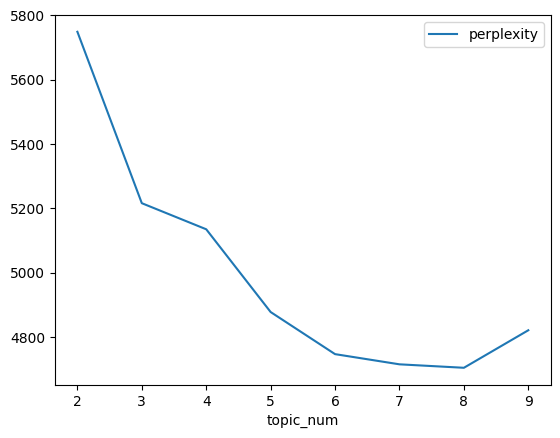

In [36]:
result.plot.line(x='topic_num', y='perplexity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

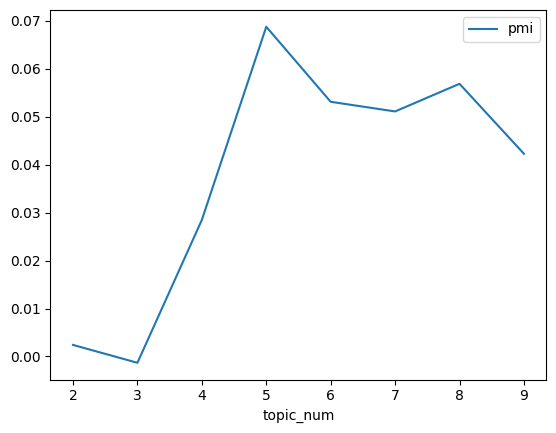

In [37]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 8是最好的，coherence 最高則是 5

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [38]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.116923 -0.028455       1        1  22.809217
0      0.029854 -0.217886       2        1  15.609033
3      0.094956 -0.000709       3        1  12.881715
7      0.073330 -0.073948       4        1  12.609419
2      0.045178  0.058499       5        1  11.688889
5      0.086106  0.155197       6        1  11.633166
6     -0.094588  0.144106       7        1   7.362251
4     -0.351758 -0.036804       8        1   5.406311, topic_info=     Term         Freq        Total Category  logprob  loglift
5293   地震  2754.000000  2754.000000  Default  30.0000  30.0000
91     發生  2903.000000  2903.000000  Default  29.0000  29.0000
8050   花蓮  1334.000000  1334.000000  Default  28.0000  28.0000
6222   天氣   820.000000   820.000000  Default  27.0000  27.0000
979    民眾  3054.000000  3054.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1399   提醒   228.710563   682.592465   Topic8  -5.2175   1.8242
91     發生   269.016421  2903.741468   Topic8  -5.0552   0.5386
349    機會   214.575822   725.170517   Topic8  -5.2813   1.6999
198    表示   223.745831  4327.534705   Topic8  -5.2394  -0.0446
419    台灣   216.077756  2608.075498   Topic8  -5.2743   0.4269

[644 rows x 6 columns], token_table=      Topic      Freq Term
term                      
134       1  0.456815   一名
134       2  0.001757   一名
134       3  0.095463   一名
134       4  0.125331   一名
134       5  0.018155   一名
...     ...       ...  ...
6262      4  0.012089   點分
6262      5  0.051380   點分
6262      6  0.181340   點分
6262      7  0.522865   點分
6262      8  0.084626   點分

[1956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 8, 3, 6, 7, 5])

可以看到(1,3,4,5,6)很相近，試試看跑4個主題




In [41]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.119211 -0.105792       1        1  29.624449
3      0.028640 -0.058598       2        1  26.711274
2      0.062741  0.178936       3        1  23.846476
0     -0.210592 -0.014546       4        1  19.817801, topic_info=     Term         Freq        Total Category  logprob  loglift
5293   地震  3090.000000  3090.000000  Default  30.0000  30.0000
8050   花蓮  1518.000000  1518.000000  Default  29.0000  29.0000
1512   中國  1538.000000  1538.000000  Default  28.0000  28.0000
6222   天氣   783.000000   783.000000  Default  27.0000  27.0000
8139   媽祖  1012.000000  1012.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
439    指出   399.170124  1634.137280   Topic4  -5.9595   0.2091
145    出現   397.282590  1651.415783   Topic4  -5.9643   0.1938
410    今日   330.424878  1000.308528   Topic4  -6.1486   0.5109
644    時間   339.357574  1566.794814   Topic4  -6.1219   0.0889
91     發生   338.426158  3222.307191   Topic4  -6.1246  -0.6350

[338 rows x 6 columns], token_table=       Topic      Freq Term
term                       
134        1  0.711406   一名
134        2  0.208010   一名
134        3  0.079484   一名
134        4  0.001127   一名
137        1  0.592567   一起
...      ...       ...  ...
12384      4  0.981214   高溫
4725       1  0.023160  鳥山明
4725       4  0.972731  鳥山明
4145       1  0.917957  黃子佼
4145       2  0.079484  黃子佼

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

可以看到(1,2)很相近，試試看跑3個主題

In [42]:
model_3 = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_3, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.062910  0.137235       1        1  39.177370
2     -0.109386 -0.114592       2        1  33.100744
0      0.172296 -0.022643       3        1  27.721886, topic_info=     Term         Freq        Total Category  logprob  loglift
5293   地震  3083.000000  3083.000000  Default  30.0000  30.0000
979    民眾  3028.000000  3028.000000  Default  29.0000  29.0000
553    美國  1818.000000  1818.000000  Default  28.0000  28.0000
1512   中國  1665.000000  1665.000000  Default  27.0000  27.0000
8050   花蓮  1492.000000  1492.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2180   持續   458.475619  1009.556897   Topic3  -6.1567   0.4936
409    今天   440.970051  1054.091540   Topic3  -6.1956   0.4115
145    出現   447.883326  1614.985614   Topic3  -6.1800   0.0004
979    民眾   468.913378  3028.802428   Topic3  -6.1342  -0.5826
91     發生   421.888179  3164.003709   Topic3  -6.2398  -0.7319

[264 rows x 6 columns], token_table=       Topic      Freq Term
term                       
134        1  0.855824   一名
134        2  0.139530   一名
134        3  0.005084   一名
137        1  0.664460   一起
137        2  0.187212   一起
...      ...       ...  ...
12384      2  0.033595   高溫
12384      3  0.965087   高溫
4145       1  0.997724  黃子佼
4145       2  0.001646  黃子佼
4145       3  0.001646  黃子佼

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

雖然分得很清楚，但是不相關的相關字也分到同一個topic(topic 3)，所以分為4個topic的結果會比較好

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [43]:
!pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /tmp/pip-install-9bhwonpj/guidedlda_cba25be20ac94629b993cdd3fdd8fd15
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /tmp/pip-install-9bhwonpj/guidedlda_cba25be20ac94629b993cdd3fdd8fd15
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done
  Created wheel for GuidedLDA: filename=guidedlda-2.0.0.dev31-cp310-cp310-linux_x86_64.whl size=2558687 sha256=84c995179245b5ab6b4ef95bbed155e470f57fac396094651d9f081c15e4370c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dft6bpkh/wheels/2e/d3/0d/45d6ae01da5e14302f3f8e8260a78d13db2e37d72bae36c0cd
Successfully built GuidedLDA


In [44]:
import guidedlda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('一下', '一場', '一時', '一直', '一聲', '三個', '三月', '上台', '上場', '不像')

In [46]:
word2id = dictionary.token2id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
seed_topic_list = [
    ["黃子佼", "影片", "女子", "網友", "孟耿如", "統神"],
    ["俄羅斯", "拜登", "以色列", "烏克蘭", "美國", "中國"],
    ["以色列", "伊朗", "哈瑪斯", "攻擊", "飛彈", "美國", "歐盟"],
    ["花蓮", "強震", "餘震", "大樓", "業者", "民眾", "人員", "時間"],
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 網友 表示 真的 一名 黃子佼 影片 發現 發文 知道 一起
Topic 1: 天氣 短暫 影響 鋒面 氣象 局部 北部 山區 陣雨 各地
Topic 2: 台灣 美國 中國 表示 日本 公司 進行 目前 使用 報導
Topic 3: 地震 發生 民眾 花蓮 已經 目前 大樓 強震 規模 表示
Topic 4: 媽祖 民眾 業者 現在 比較 活動 一起 台灣 今年 店家


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.182811 -0.011264       1        1  29.973815
4     -0.087880 -0.212350       2        1  23.851580
3     -0.010611 -0.022713       3        1  20.897318
2     -0.074092  0.252638       4        1  17.790633
1      0.355393 -0.006312       5        1   7.486654, topic_info=     Term         Freq        Total Category  logprob  loglift
5293   地震  2732.000000  2732.000000  Default  30.0000  30.0000
272    網友  2795.000000  2795.000000  Default  29.0000  29.0000
91     發生  2689.000000  2689.000000  Default  28.0000  28.0000
6222   天氣   852.000000   852.000000  Default  27.0000  27.0000
8050   花蓮  1458.000000  1458.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
198    表示   405.019809  4330.057051   Topic5  -4.9715   0.2226
410    今日   317.234426  1094.470413   Topic5  -5.2158   1.3537
439    指出   312.246621  1502.989019   Topic5  -5.2317   1.0206
2180   持續   289.302714  1053.464784   Topic5  -5.3080   1.2997
1522   大陸   272.344174   980.711197   Topic5  -5.3684   1.3108

[355 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1177       1  0.167362   一些
1177       2  0.540124   一些
1177       3  0.098896   一些
1177       4  0.060859   一些
1177       5  0.133890   一些
...      ...       ...  ...
12384      2  0.033016   高溫
12384      5  0.966905   高溫
4725       4  1.000891  鳥山明
12933      2  1.000581  麥當勞
4145       1  0.999850  黃子佼

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

In [53]:
seed_topic_list = [
    ["黃子佼", "影片", "女子", "網友", "孟耿如", "統神", "粉絲", "曝光"],
    ["俄羅斯", "拜登", "以色列", "烏克蘭", "美國", "中國"],
    ["以色列", "伊朗", "哈瑪斯", "攻擊", "飛彈", "美國", "歐盟"],
    ["花蓮", "強震", "餘震", "大樓", "業者", "民眾", "人員", "時間", "山區", "搜救"],
    ["台灣", "媽祖", "活動", "希望", "白沙", "經濟", "進香"],
    ["天氣","氣象","鋒面","大雨", "豪雨", "陣雨"],
    ["民眾","業者","店家","衛生局","消費者","餐廳","蘇丹紅","老闆","食品","員工"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
model = guidedlda.GuidedLDA(n_topics=8, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 網友 表示 真的 黃子佼 影片 發文 知道 一名 對方 一起
Topic 1: 台灣 中國 美國 表示 公司 日本 全球 總統 國家 政府
Topic 2: 發生 警方 表示 目前 發現 報導 男子 醫院 一名 事件
Topic 3: 地震 花蓮 發生 民眾 大樓 強震 已經 規模 目前 搜救
Topic 4: 媽祖 台灣 活動 日本 今年 白沙 一起 希望 粉絲 許多
Topic 5: 天氣 氣象 短暫 鋒面 局部 北部 影響 陣雨 山區 各地
Topic 6: 業者 民眾 現在 店家 衛生局 問題 老闆 消費者 使用 餐廳
Topic 7: 工作 生活 時間 容易 健康 需要 老師 機會 朋友 比較


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.154455  0.033767       1        1  23.461801
3     -0.036691  0.181447       2        1  16.173432
6      0.066270  0.021616       3        1  14.108400
7      0.026633 -0.212295       4        1  11.088038
1      0.048644 -0.102457       5        1  10.617665
4      0.095763 -0.135573       6        1  10.533586
2      0.043024  0.246242       7        1   9.222086
5     -0.398098 -0.032745       8        1   4.794993, topic_info=     Term         Freq        Total Category  logprob  loglift
5293   地震  2731.000000  2731.000000  Default  30.0000  30.0000
272    網友  2794.000000  2794.000000  Default  29.0000  29.0000
8139   媽祖  1155.000000  1155.000000  Default  28.0000  28.0000
91     發生  2687.000000  2687.000000  Default  27.0000  27.0000
6222   天氣   850.000000   850.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
3495   中央   280.937637   476.672648   Topic8  -4.8918   2.5089
410    今日   265.994676  1093.713625   Topic8  -4.9465   1.6237
91     發生   268.983268  2687.775798   Topic8  -4.9353   0.7358
1522   大陸   241.089740   979.905965   Topic8  -5.0448   1.6353
198    表示   245.074530  4327.409464   Topic8  -5.0284   0.1664

[579 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1177       1  0.140078   一些
1177       2  0.091355   一些
1177       3  0.158349   一些
1177       4  0.385215   一些
1177       5  0.063949   一些
...      ...       ...  ...
12384      8  0.956313   高溫
4725       6  1.001546  鳥山明
12984      7  1.000672   麻疹
4145       1  1.000179  黃子佼
14343      4  1.000398   龍王

[1250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 7, 8, 2, 5, 3, 6])

## 7. 主題分佈的應用，搭配其他文章資訊

In [56]:
# 取得每條新聞的主題分佈
topics_doc = model_4.get_document_topics(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
topics_doc[100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.044330593), (1, 0.6436616), (3, 0.30915248)]

In [58]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.11334573, 0.73636442, 0.0275183 , 0.12277156],
       [0.02425653, 0.97077399, 0.        , 0.        ],
       [0.        , 0.99354815, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.37415427, 0.62160361],
       [0.        , 0.99604094, 0.        , 0.        ],
       [0.91899425, 0.        , 0.07628264, 0.        ]])

In [59]:
data['topic_label'] = m_theta.argmax(axis=1)+1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
data['topic_label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label
2    1696
4    1513
3    1326
1     917
Name: count, dtype: int64

In [61]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words,topic_label
0,啦啦隊女孩外表看起來光鮮亮麗其實生活壓力非常大尤其剛出道的啦啦隊上場次數不多薪水並不高東森新...,https://news.ebc.net.tw/news/article/407763,娛樂,2024-03-01 07:00:00,"[啦啦隊, 女孩, 外表, 光鮮亮麗, 生活, 壓力, 尤其, 剛出道, 啦啦隊, 上場, ...",2
1,男星王中平與余皓然結婚年一家四口相當幸福可以說是演藝圈的模範夫妻沒想到余皓然近期卻自曝兩人離...,https://news.ebc.net.tw/news/article/407782,娛樂,2024-03-01 11:14:00,"[男星, 王中平, 皓然, 結婚, 一家, 四口, 相當, 幸福, 演藝圈, 模範, 夫妻,...",2
2,綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿軒為大眾所熟識而憲哥曾公開稱讚小女兒吳...,https://news.ebc.net.tw/news/article/407801,娛樂,2024-03-01 12:33:00,"[綜藝, 天王, 吳宗憲, 女子, 女兒, 吳姍儒, 小兒子, 鹿希派, 吳睿軒, 大眾, ...",2
3,女星歐若拉去年與交往個月的男友閃婚原以為對方是真命天子沒想到事後發現前夫外遇吸毒而歐若拉竟然...,https://news.ebc.net.tw/news/article/407880,娛樂,2024-03-01 19:22:00,"[女星, 歐若拉, 去年, 交往, 男友, 閃婚, 原以, 對方, 真命天子, 沒想到, 事...",2
4,台灣正妹網紅胎尼以大尺度風格在網上擁有不小的人氣在社群舊名上有超過萬追隨者平時就在自己拍攝大...,https://news.ebc.net.tw/news/article/407909,娛樂,2024-03-01 22:11:00,"[台灣, 正妹, 網紅, 胎尼以, 尺度, 風格, 網上, 擁有, 不小, 人氣, 社群, ...",2


In [62]:
data['artDate'] = pd.to_datetime(data['artDate'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
data['artDate'].dt.date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       2024-03-01
1       2024-03-01
2       2024-03-01
3       2024-03-01
4       2024-03-01
           ...    
5447    2024-04-25
5448    2024-04-25
5449    2024-04-25
5450    2024-04-25
5451    2024-04-25
Name: artDate, Length: 5452, dtype: object

In [64]:
data.groupby(data['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artDate     topic_label
2024-03-01  2              0.370968
            4              0.322581
            1              0.241935
            3              0.064516
2024-03-02  2              0.425287
                             ...   
2024-04-24  1              0.178571
2024-04-25  2              0.312500
            3              0.250000
            1              0.229167
            4              0.208333
Name: proportion, Length: 224, dtype: float64

In [65]:
date_topic = data.groupby(data['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4
artDate,,,,
2024-03-01,0.241935,0.370968,0.064516,0.322581
2024-03-02,0.160920,0.425287,0.126437,0.287356
2024-03-03,0.222222,0.305556,0.069444,0.402778
2024-03-04,0.176471,0.215686,0.117647,0.490196
2024-03-05,0.257426,0.277228,0.168317,0.297030


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


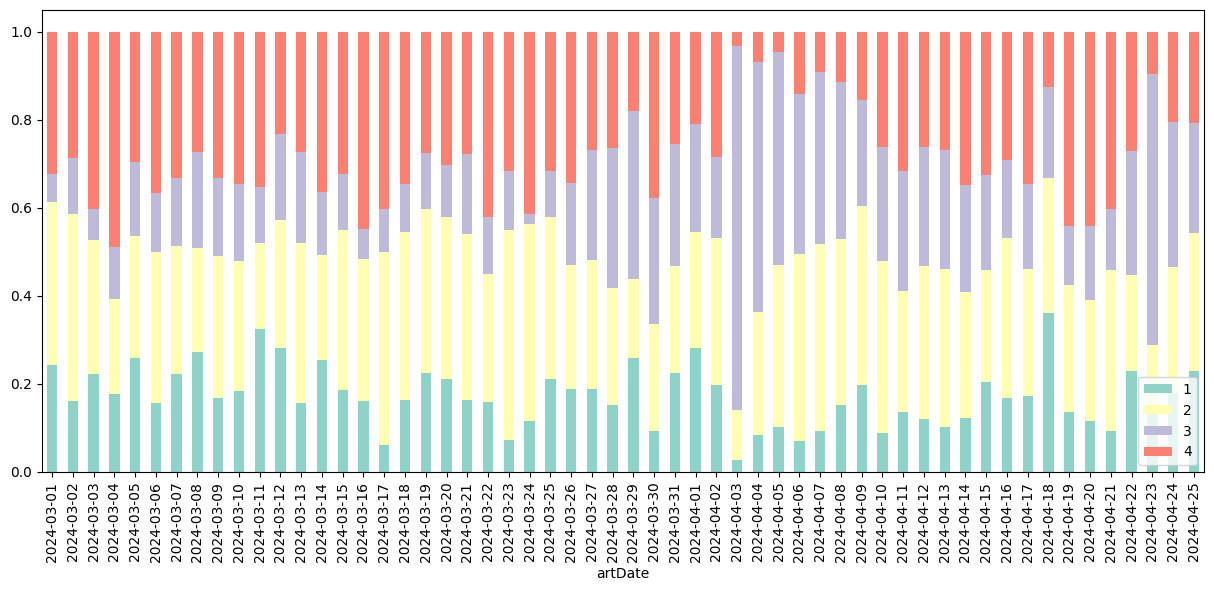

In [66]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到分群3（生活）相關新聞在 4/3 被討論的比例很高，也就是台灣發生花蓮大地震的日期<br>


# Text Presentation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Social_Media_Analysis/HW3')

Mounted at /content/drive


In [3]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

In [4]:
origin_data = pd.read_csv("raw_data/living_world_entertainment_20240401to30_ebc.csv")  # 匯資料
origin_data.head(5)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,娛樂,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,EBC
1,2,結婚28年！余皓然突爆「前陣子離婚」 無奈真相曝光｜東森新聞,https://news.ebc.net.tw/news/article/407782,2024-03-01 11:14:00,娛樂,男星王中平與余皓然結婚28年，一家四口相當幸福，可以說是演藝圈的模範夫妻，沒想到余皓然近期卻...,EBC
2,3,勝過Sandy！吳宗憲「最美三女兒」高顏值曝光｜東森新聞,https://news.ebc.net.tw/news/article/407801,2024-03-01 12:33:00,娛樂,綜藝天王吳宗憲有3女1子，其中大女兒Sandy（吳姍儒）和小兒子鹿希派（吳睿軒）為大眾所熟識...,EBC
3,4,歐若拉交往3個月閃婚！尪偷吃還嗑藥 上門對質驚呆｜東森新聞,https://news.ebc.net.tw/news/article/407880,2024-03-01 19:22:00,娛樂,女星歐若拉去年與交往3個月的男友閃婚，原以為對方是真命天子，沒想到事後發現前夫外遇、吸毒，而...,EBC
4,5,網紅Tiny赴日「當女優」遭欺負 拍完4個月0片酬｜東森新聞,https://news.ebc.net.tw/news/article/407909,2024-03-01 22:11:00,娛樂,台灣正妹網紅TinyLu（胎尼）以大尺度風格，在網上擁有不小的人氣，在X社群（舊名Twitt...,EBC


In [24]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopWords+=["尤其","表示","現在","目前","已經","年來","事實上","哈林","近日"
      ,"日前","稍早","瞬間","一出","左右","寫下","現身","關注","台中市"
      ,"帶領","東縣","確保","地區"]


In [6]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [25]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artCatagory', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/HW3/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/HW3/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ue0031ce2155a9ef6090ec1cd6878d3e5.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.ue0031ce2155a9ef6090ec1cd6878d3e5.cache
Loading model cost 1.561 seconds.
DEBUG:jieba:Loading model cost 1.561 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artTitle,artUrl,artDate,artContent,sentence,word
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,啦啦隊女孩外表看起來光鮮亮麗,"[啦啦隊, 女孩, 外表, 光鮮亮麗]"
1,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,其實生活壓力非常大,"[生活, 壓力]"
2,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,尤其剛出道的啦啦隊,"[剛出道, 啦啦隊]"
3,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,上場次數不多薪水並不高,"[上場, 次數, 薪水, 並不高]"
4,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,東森新聞獨家採訪到樂天女孩成員禹菡音漢,"[東森, 新聞, 獨家, 採訪, 樂天, 女孩, 成員, 禹菡, 音漢]"
...,...,...,...,...,...,...,...
241738,5452,曼谷發布極端高溫警告 泰國今年至少30人中暑喪生｜東森新聞,https://news.ebc.net.tw/news/article/417299,2024-04-25 23:30:00,泰國政府今天（25日）就酷熱高溫再次發出警告，稱今年已有至少30人因中暑喪生。首都曼谷當局也...,泰國疾病管制署副署長狄瑞克告訴法新社,"[泰國, 疾病, 管制, 署長, 瑞克, 告訴, 法新社]"
241739,5452,曼谷發布極端高溫警告 泰國今年至少30人中暑喪生｜東森新聞,https://news.ebc.net.tw/news/article/417299,2024-04-25 23:30:00,泰國政府今天（25日）就酷熱高溫再次發出警告，稱今年已有至少30人因中暑喪生。首都曼谷當局也...,官員呼籲年長者和患有肥胖症等疾病的民眾留在室內,"[官員, 呼籲, 年長者, 患有, 肥胖症, 疾病, 民眾, 留在, 室內]"
241740,5452,曼谷發布極端高溫警告 泰國今年至少30人中暑喪生｜東森新聞,https://news.ebc.net.tw/news/article/417299,2024-04-25 23:30:00,泰國政府今天（25日）就酷熱高溫再次發出警告，稱今年已有至少30人因中暑喪生。首都曼谷當局也...,並隨時補充水分,"[隨時, 補充, 水分]"
241741,5452,曼谷發布極端高溫警告 泰國今年至少30人中暑喪生｜東森新聞,https://news.ebc.net.tw/news/article/417299,2024-04-25 23:30:00,泰國政府今天（25日）就酷熱高溫再次發出警告，稱今年已有至少30人因中暑喪生。首都曼谷當局也...,月通常是泰國和其他東南亞國家年中最熱的月份,"[通常, 泰國, 東南亞, 國家, 最熱, 月份]"


### 訓練word2vec模型

In [26]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artTitle,artUrl,artDate,artContent,sentence,word,word_list_bigrams
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,啦啦隊女孩外表看起來光鮮亮麗,"[啦啦隊, 女孩, 外表, 光鮮亮麗]","[啦啦隊, 女孩, 外表, 光鮮亮麗]"
1,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,其實生活壓力非常大,"[生活, 壓力]","[生活, 壓力]"
2,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,尤其剛出道的啦啦隊,"[剛出道, 啦啦隊]","[剛出道, 啦啦隊]"
3,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,上場次數不多薪水並不高,"[上場, 次數, 薪水, 並不高]","[上場, 次數, 薪水, 並不高]"
4,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,東森新聞獨家採訪到樂天女孩成員禹菡音漢,"[東森, 新聞, 獨家, 採訪, 樂天, 女孩, 成員, 禹菡, 音漢]","[東森, 新聞, 獨家, 採訪, 樂天_女孩, 成員, 禹菡, 音漢]"


In [27]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [10]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 89992


['民眾', '網友', '地震', '台灣', '發生', '發現', '真的', '影響', '一起', '時間']

In [11]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 231187
average length of sentences: 3.6674077694680065


In [12]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [13]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [28]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

In [47]:
# 檢查最相關的字
w2v_model.wv.most_similar('台灣',topn=10)

[('日本', 0.704882025718689),
 ('城市', 0.6521695256233215),
 ('香港', 0.6512694954872131),
 ('世界', 0.6495700478553772),
 ('國家', 0.6488873958587646),
 ('東京', 0.6468960046768188),
 ('亞洲', 0.6395588517189026),
 ('全球', 0.6349051594734192),
 ('成為', 0.631308376789093),
 ('經濟', 0.6271452307701111)]

In [48]:
# 檢查最相關的字
w2v_model.wv.most_similar('地震',topn=10)

[('強震', 0.8336402773857117),
 ('餘震', 0.7677451968193054),
 ('震撼', 0.7045077681541443),
 ('芮氏', 0.7038581371307373),
 ('有感', 0.6898661851882935),
 ('主震', 0.6883118748664856),
 ('規模', 0.67913419008255),
 ('餘震不斷', 0.6748510599136353),
 ('接連', 0.6727842688560486),
 ('多起', 0.6725695133209229)]

In [49]:
w2v_model.wv.most_similar(['台灣','地震'],topn=10)

[('有感', 0.7227560877799988),
 ('最強', 0.7220520973205566),
 ('接連', 0.720996081829071),
 ('震災', 0.7192025780677795),
 ('規模', 0.718125581741333),
 ('芮氏', 0.7159755229949951),
 ('強震', 0.7094419002532959),
 ('連續', 0.7068759799003601),
 ('太平洋', 0.7060698866844177),
 ('凌晨時分', 0.7060011625289917)]

In [18]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['台灣','地震'],topn=10)

[('放低_重心', -0.03400370851159096),
 ('處理', -0.07028159499168396),
 ('進行', -0.0939355194568634),
 ('要求', -0.1015193834900856),
 ('萬元', -0.10826276987791061),
 ('保護', -0.11332888156175613),
 ('相關', -0.11505831778049469),
 ('提供', -0.11568064242601395),
 ('購買', -0.11932985484600067),
 ('媽祖', -0.12003438174724579)]

In [19]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['餐廳','火鍋'],topn=10)

[('部位_露出', 0.014767243526875973),
 ('放低_重心', 0.005836854223161936),
 ('媽祖', -0.24002902209758759),
 ('天氣', -0.24416254460811615),
 ('鋒面', -0.2682221233844757),
 ('氣溫', -0.2734830379486084),
 ('發生', -0.2831827700138092),
 ('今日', -0.2865987718105316),
 ('溫度', -0.2895545959472656),
 ('清晨', -0.29370197653770447)]

In [20]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("泰國","日本")

0.7289661

In [21]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["媽祖", "進香", '台灣'])

'台灣'

In [22]:
# 相對關係
w2v_model.wv.most_similar(positive=["媽祖"], negative=["日本"], topn=5)

[('進香', 0.47887948155403137),
 ('天宮', 0.4676741659641266),
 ('祈求', 0.39825108647346497),
 ('白沙', 0.39780130982398987),
 ('平安', 0.3868430256843567)]

In [15]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [16]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [17]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [26]:
getVecs(w2v_model,['媽祖','地震'])

array([[ 0.35884988, -0.7888575 , -0.02438632, -0.28928962, -0.19832613,
         0.51079786,  0.09016175,  0.26982453, -0.7396825 ,  0.81845134,
        -0.09781614, -0.36301228,  0.5351073 ,  0.19785295,  0.31754118,
         0.09395063, -0.01846188, -0.24299112, -0.19517191, -0.6798043 ,
        -0.10693818, -0.2664293 ,  0.92832124, -0.26115966,  0.08957946,
         0.49024475, -0.02443087, -0.3875795 ,  0.338658  , -0.00647956,
        -0.0762652 ,  1.5158936 , -0.5181992 ,  0.26002777, -0.25065953,
         0.04009432,  0.35040626,  0.4074941 , -0.3253285 , -0.18348387,
        -0.6092871 ,  0.96257675, -0.35121387, -0.21681039,  0.22192504,
         0.04218049, -0.01749717, -0.40018213,  0.3767311 ,  0.05893457,
         1.068688  ,  0.0813181 , -0.8934999 ,  0.16769621, -0.9636257 ,
         0.32789028, -0.5862467 , -1.2155776 , -0.78528565,  0.5041276 ,
        -0.13437495,  0.287265  , -0.27771676,  0.3415535 ,  0.8061137 ,
         0.55922157,  0.3951965 , -0.3151077 ,  0.6

In [18]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [28]:
expandPosWord(w2v_model,['媽祖','進香'],top_n = 10)

['粉紅_超跑', '進香', '起駕', '天宮', '白沙', '北港', '大甲', '跟隨', '天夜', '祈求', '一年一度', '姊妹']

In [29]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [30]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [31]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

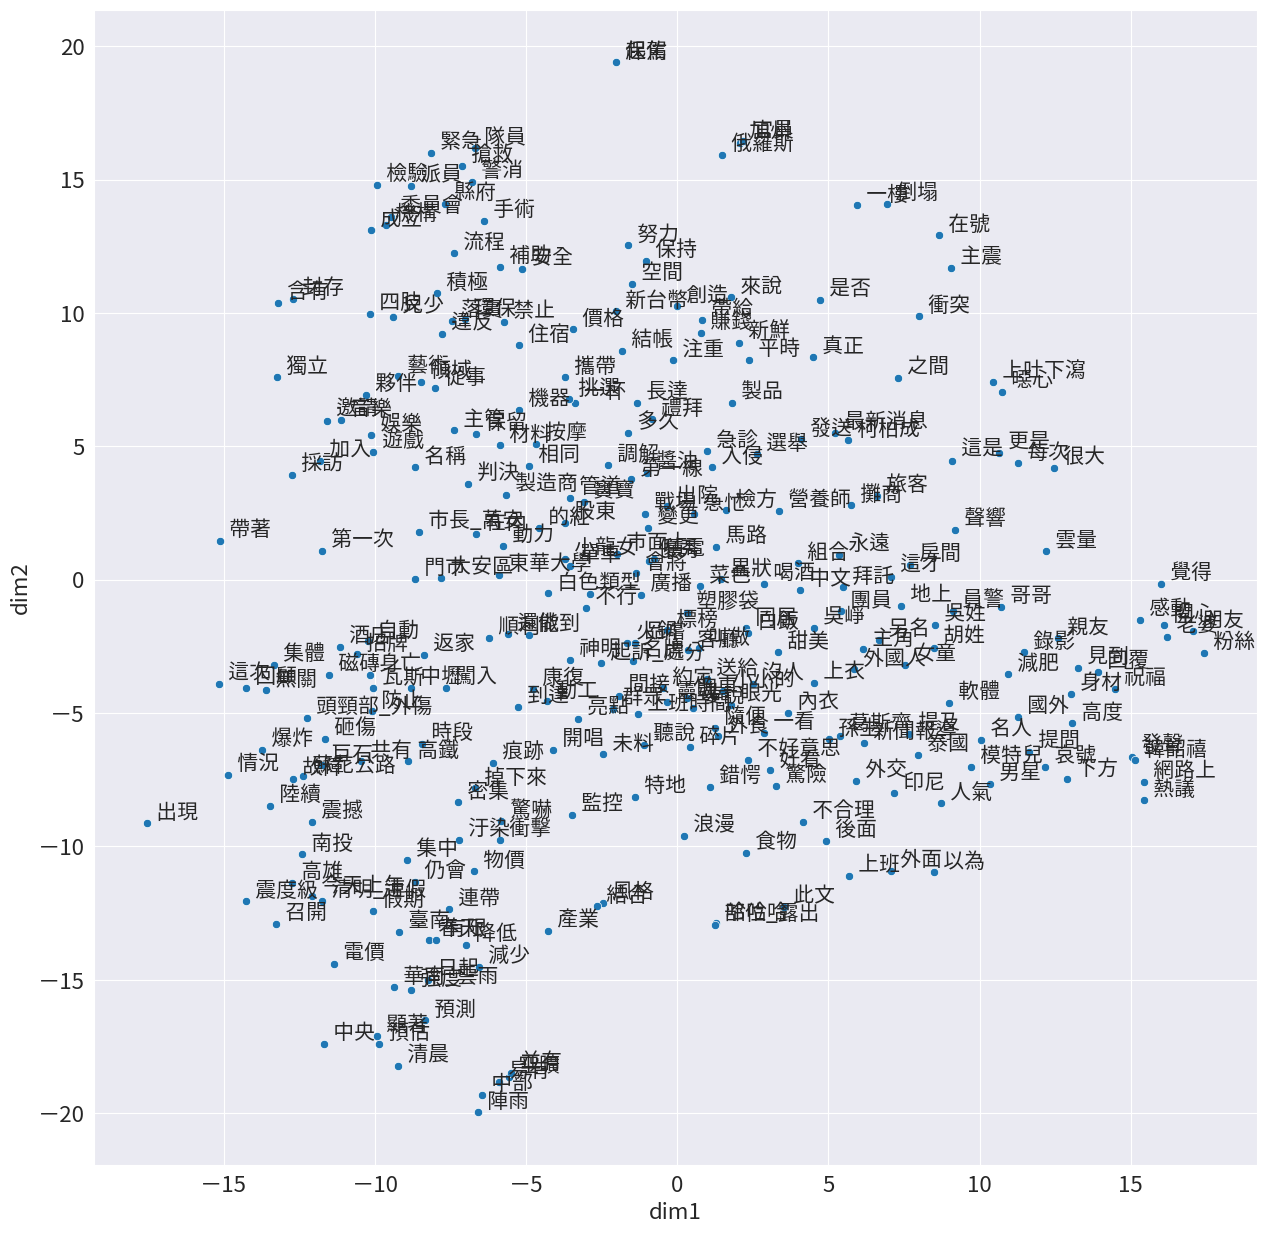

In [32]:
plotScatter(word_df)

In [33]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [34]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.5 MB/s eta 0:00:00


In [35]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [36]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=6),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Transformers Embeddings

In [37]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

小模型Bert: 中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [ ]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

大模型範例

In [ ]:
!pip install tiktoken
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=425fc418ac5c59b9244c45bd81a666b11171b4b93bf88b0a5fef9e3f045cf833
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


cohere

In [ ]:
!pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00


In [ ]:
import cohere
from google.colab import userdata
COHERE_API_KEY = userdata.get('COHERE_API_KEY')
COHERE_API_KEY_MM6 = userdata.get('COHERE_API_KEY_MM6')

co = cohere.Client(COHERE_API_KEY_MM6) # 設置API_KEY

embedding_model = "embed-multilingual-v3.0"

def get_embedding_cohere(text, model):
   #text = text.replace("\n", " ")
   return co.embed(texts=[text], model=model, input_type="classification").embeddings[0]

### 使用embedding做NLP任務

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

<ipython-input-44-ba0ea2bb5f29>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,啦啦隊女孩外表看起來光鮮亮麗其實生活壓力非常大尤其剛出道的啦啦隊上場次數不多薪水並不高東森新...
1,2,結婚28年！余皓然突爆「前陣子離婚」 無奈真相曝光｜東森新聞,男星王中平與余皓然結婚年一家四口相當幸福可以說是演藝圈的模範夫妻沒想到余皓然近期卻自曝兩人離...
2,3,勝過Sandy！吳宗憲「最美三女兒」高顏值曝光｜東森新聞,綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿軒為大眾所熟識而憲哥曾公開稱讚小女兒吳...
3,4,歐若拉交往3個月閃婚！尪偷吃還嗑藥 上門對質驚呆｜東森新聞,女星歐若拉去年與交往個月的男友閃婚原以為對方是真命天子沒想到事後發現前夫外遇吸毒而歐若拉竟然...
4,5,網紅Tiny赴日「當女優」遭欺負 拍完4個月0片酬｜東森新聞,台灣正妹網紅胎尼以大尺度風格在網上擁有不小的人氣在社群舊名上有超過萬追隨者平時就在自己拍攝大...


### Bert_CH

In [ ]:
corpus_embeddings_bert = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)


In [ ]:

query_num = 50 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings_bert)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 17LIVE調整全球布局 台灣區裁員人數未公布｜東森新聞

 資料集中前五相似的文章:
17LIVE調整全球布局 台灣區裁員人數未公布｜東森新聞 (Score: 1.0000)
來滋烤鴨剛收攤 王品Hot 7鐵板燒南台灣首分店也熄燈｜東森新聞 (Score: 0.9719)
世界第三大！金融公司將裁員1000人 台灣也有分部｜東森新聞 (Score: 0.9716)
Lululemon股價暴跌31％ 大裁128名員工｜東森新聞 (Score: 0.9706)
為省50億！知名製藥公司爆裁員 逾500人丟飯碗｜東森新聞 (Score: 0.9697)






### Cohere

In [ ]:
df_similar['artContent']

0       啦啦隊女孩外表看起來光鮮亮麗其實生活壓力非常大尤其剛出道的啦啦隊上場次數不多薪水並不高東森新...
1       男星王中平與余皓然結婚年一家四口相當幸福可以說是演藝圈的模範夫妻沒想到余皓然近期卻自曝兩人離...
2       綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿軒為大眾所熟識而憲哥曾公開稱讚小女兒吳...
3       女星歐若拉去年與交往個月的男友閃婚原以為對方是真命天子沒想到事後發現前夫外遇吸毒而歐若拉竟然...
4       台灣正妹網紅胎尼以大尺度風格在網上擁有不小的人氣在社群舊名上有超過萬追隨者平時就在自己拍攝大...
                              ...                        
5447    台積電在台靠賣肝文化獲得的成功卻難以在國外複製美國媒體近日報導有台積電在美國的工程師爆料內部...
5448    中國大陸神舟號載人飛船今日晚間在甘肅的酒泉衛星發射中心發射載著名後的太空人航向中國太空站對此...
5449    滿滿飯菜裝在保麗龍餐盒裡套進塑膠袋打包帶走或是電影無間道裡曾志偉在警局大嗑飯盒的經典鏡頭這類...
5450    中國大陸四川發生借屍還魂懸案一名王姓丈夫輕生死亡天後竟在停屍間復活當場嚇壞余姓妻子及親友且令...
5451    泰國政府今天日就酷熱高溫再次發出警告稱今年已有至少人因中暑喪生首都曼谷當局也發出極端高溫預警...
Name: artContent, Length: 5452, dtype: object

In [ ]:
import time

# 設定每分鐘處理的資料量
batch_size = 90
# 計算處理一筆資料所需的時間（秒）
time_per_item = 60
corpus_embeddings=[]
# 將資料分成多個批次，每個批次處理 batch_size 筆資料
for i in range(0, len(df_similar), batch_size):
    # 獲取批次資料
    batch_texts = df_similar['artContent'][i:min(i+batch_size, len(df_similar))]
    # 對批次資料進行處理
    corpus_embeddings_batch = [get_embedding_cohere(text, model=embedding_model) for text in batch_texts]
    # 等待一段時間，以控制處理速率
    time.sleep(time_per_item)
    corpus_embeddings.extend(corpus_embeddings_batch)


TooManyRequestsError: status_code: 429, body: {'message': "You are using a Trial key, which is limited to 1000 API calls / month. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us at support@cohere.com with any questions"}

In [ ]:
len(corpus_embeddings)

720

In [ ]:
# corpus_embeddings = [get_embedding_cohere(text, model=embedding_model) for text in df_similar['artContent']]

query_num = 100

query_embedding = get_embedding_cohere(df_similar['artContent'][query_num], model=embedding_model)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 張蘭還原「大S赴靈堂穿著」 認了蹭流量下場慘｜東森新聞

 資料集中前五相似的文章:
張蘭還原「大S赴靈堂穿著」 認了蹭流量下場慘｜東森新聞 (Score: 1.0000)
張蘭「仿靈堂穿搭」挨批助長施暴！大S也發聲反擊｜東森新聞 (Score: 0.8645)
遭張蘭酸「赴靈堂穿著」 大S不忍發聲了｜東森新聞 (Score: 0.8479)
大S靈堂穿搭疑是前夫刷卡 汪小菲直播遭問秒下線｜東森新聞 (Score: 0.8462)
汪小菲撤告大S！憔悴現身張蘭直播「雙眼紅腫」｜東森新聞 (Score: 0.8394)






In [ ]:
# corpus_embeddings = [get_embedding_cohere(text, model=embedding_model) for text in df_similar['artContent']]

query_num = 700

query_embedding = get_embedding_cohere(df_similar['artContent'][query_num], model=embedding_model)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 小紅老師也是受害人 揭黃子佼「釣妞」慣用手法｜東森新聞

 資料集中前五相似的文章:
小紅老師也是受害人 揭黃子佼「釣妞」慣用手法｜東森新聞 (Score: 1.0000)
黃子佼再爆性侵！吹哨者貼文被3度刪除 李怡貞分析原因｜東森新聞 (Score: 0.9139)
遭黃子佼逼換泳裝後性侵！Zofia：還有受害者｜東森新聞 (Score: 0.8851)
黃子佼爆性侵17歲少女！完事後還趕電視台錄影｜東森新聞 (Score: 0.8781)
黃子佼被害人+1 企業家二代淚訴17歲遭性侵過程｜東森新聞 (Score: 0.8757)






### 分類任務

In [ ]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [ ]:
data3 = pd.read_csv("./raw_data/living_world_entertainment_20240401to30_ebc.csv")
data3.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,獨家／2個月沒薪水！樂天女孩禹菡「椎間盤突出」無職災給付｜東森新聞,https://news.ebc.net.tw/news/article/407763,2024-03-01 07:00:00,娛樂,啦啦隊女孩外表看起來光鮮亮麗，其實生活壓力非常大，尤其剛出道的啦啦隊，上場次數不多薪水並不高...,EBC
1,2,結婚28年！余皓然突爆「前陣子離婚」 無奈真相曝光｜東森新聞,https://news.ebc.net.tw/news/article/407782,2024-03-01 11:14:00,娛樂,男星王中平與余皓然結婚28年，一家四口相當幸福，可以說是演藝圈的模範夫妻，沒想到余皓然近期卻...,EBC
2,3,勝過Sandy！吳宗憲「最美三女兒」高顏值曝光｜東森新聞,https://news.ebc.net.tw/news/article/407801,2024-03-01 12:33:00,娛樂,綜藝天王吳宗憲有3女1子，其中大女兒Sandy（吳姍儒）和小兒子鹿希派（吳睿軒）為大眾所熟識...,EBC


In [ ]:
# 過濾 nan 的資料
data3 = data3.dropna(subset=['artTitle'])
data3 = data3.dropna(subset=['artContent'])
# 移除網址格式
data3["artContent"] = data3.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
data3["artTitle"] = data3["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
data3["artContent"] = data3.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
data3["artTitle"] = data3["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
data3["content"] = data3["artTitle"] + data3["artContent"]
data3 = data3[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
data3.head()

,content,artUrl,artCatagory
0,獨家個月沒薪水樂天女孩禹菡椎間盤突出無職災給付東森新聞啦啦隊女孩外表看起來光鮮亮麗其實生活壓...,https://news.ebc.net.tw/news/article/407763,娛樂
1,結婚年余皓然突爆前陣子離婚無奈真相曝光東森新聞男星王中平與余皓然結婚年一家四口相當幸福可以說...,https://news.ebc.net.tw/news/article/407782,娛樂
2,勝過吳宗憲最美三女兒高顏值曝光東森新聞綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿...,https://news.ebc.net.tw/news/article/407801,娛樂
3,歐若拉交往個月閃婚尪偷吃還嗑藥上門對質驚呆東森新聞女星歐若拉去年與交往個月的男友閃婚原以為對...,https://news.ebc.net.tw/news/article/407880,娛樂
4,網紅赴日當女優遭欺負拍完個月片酬東森新聞台灣正妹網紅胎尼以大尺度風格在網上擁有不小的人氣在社...,https://news.ebc.net.tw/news/article/407909,娛樂


In [ ]:
data3["embeddings"] = data3.content.apply(lambda x: bert_ch.encode(x))
data3.head(3)

,content,artUrl,artCatagory,embeddings
0,獨家個月沒薪水樂天女孩禹菡椎間盤突出無職災給付東森新聞啦啦隊女孩外表看起來光鮮亮麗其實生活壓...,https://news.ebc.net.tw/news/article/407763,娛樂,"[0.4932148, -0.28984925, -0.17072217, 0.363695..."
1,結婚年余皓然突爆前陣子離婚無奈真相曝光東森新聞男星王中平與余皓然結婚年一家四口相當幸福可以說...,https://news.ebc.net.tw/news/article/407782,娛樂,"[0.61035293, -0.15348823, -0.18731342, 0.19686..."
2,勝過吳宗憲最美三女兒高顏值曝光東森新聞綜藝天王吳宗憲有女子其中大女兒吳姍儒和小兒子鹿希派吳睿...,https://news.ebc.net.tw/news/article/407801,娛樂,"[0.66495126, -0.0796623, -0.113200724, 0.38483..."


In [ ]:
import numpy as np
from ast import literal_eval

In [ ]:
data4 = data3.copy()

X = data4["embeddings"].apply(pd.Series)
y = data4["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
5182  0.368086 -0.203214 -0.322807 -0.079430  0.124907  0.058069 -0.284852   
4868  0.395518 -0.160741 -0.277617  0.199334  0.073035 -0.070676 -0.226473   
61    0.449267 -0.198412 -0.314988  0.310397 -0.045430 -0.249415 -0.178091   
5200  0.668142 -0.121818 -0.369516  0.311295 -0.336049 -0.328537 -0.142700   
802   0.205883  0.027402 -0.239094  0.147471 -0.173888 -0.235137 -0.048744   

           7         8         9    ...       758       759       760  \
5182 -0.067163 -0.015067 -0.447160  ...  0.076205 -0.531368  0.146253   
4868  0.091845 -0.221580 -0.118184  ...  0.012070 -0.498884  0.224232   
61    0.004937 -0.258321 -0.371008  ...  0.198559 -0.252641  0.285478   
5200  0.132742 -0.168648 -0.196488  ...  0.201852 -0.422611  0.055914   
802  -0.049278 -0.118083  0.063970  ... -0.294676  0.055761  0.132862   

           761       762       763       764       765       766       767  
5182  0.158303 

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['生活' '生活' '生活' '娛樂' '國際' '生活' '生活' '生活' '娛樂' '國際']


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.93      0.89      0.91       323
          娛樂       0.92      0.90      0.91       315
          生活       0.95      0.97      0.96       998

    accuracy                           0.94      1636
   macro avg       0.93      0.92      0.93      1636
weighted avg       0.94      0.94      0.94      1636

